In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
words = open("names.txt", "r").read().splitlines()
print(len(words))
print(max(len(word) for word in words))
print(words[:8])


32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
chars = sorted(set("".join(words)))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
import random

random.seed(42)
random.shuffle(words)


In [35]:
block_size = 8


def build_dataset(words: list[str]):
    X, Y = [], []

    for word in words:
        context = [0] * block_size

        for char in word + ".":
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X, Y = torch.tensor(X), torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])


torch.Size([182437, 8]) torch.Size([182437])
torch.Size([22781, 8]) torch.Size([22781])
torch.Size([22928, 8]) torch.Size([22928])


In [36]:
for x, y in zip(X_train[:20], Y_train[:20]):
    print("".join(itos[int(ix.item())] for ix in x), "--->", itos[int(y.item())])


........ ---> t
.......t ---> a
......ta ---> u
.....tau ---> r
....taur ---> e
...taure ---> n
..tauren ---> .
........ ---> s
.......s ---> u
......su ---> l
.....sul ---> e
....sule ---> m
...sulem ---> a
..sulema ---> n
.suleman ---> .
........ ---> z
.......z ---> e
......ze ---> r
.....zer ---> e
....zere ---> n


In [57]:
from typing import Callable


class Linear:
    weight: torch.Tensor
    bias: torch.Tensor | None

    def __init__(self, fan_in: int, fan_out: int, bias=True) -> None:
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5  # kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out = x @ self.weight

        if self.bias is not None:
            self.out += self.bias

        return self.out

    def parameters(self) -> list[torch.Tensor]:
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    eps: float
    momentum: float
    training: bool

    gamma: torch.Tensor
    beta: torch.Tensor

    running_mean: torch.Tensor
    running_var: torch.Tensor

    def __init__(self, dim: int, eps=1e-5, momentum=0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained with a running "momentum update")
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            else:
                raise ValueError("Dim invalid")
            xmean = x.mean(dim, keepdim=True)  # batch mean
            xvar = x.var(dim, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self) -> list[torch.Tensor]:
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out = torch.tanh(x)
        return self.out

    def parameters(self) -> list[torch.Tensor]:
        return []


class Embedding:
    weight: torch.Tensor

    def __init__(self, num_embeddings: int, embedding_dim: int) -> None:
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX: torch.Tensor) -> torch.Tensor:
        self.out = self.weight[IX]
        return self.out

    def parameters(self) -> list[torch.Tensor]:
        return [self.weight]


class FlattenConsecutive:
    n: int

    def __init__(self, n: int) -> None:
        self.n = n

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        B, T, C = x.shape
        out = x.view((B, T // self.n, C * self.n))

        if out.shape[1] == 1:
            out = out.squeeze(1)

        self.out = out

        return self.out

    def parameters(self) -> list[torch.Tensor]:
        return []


class Sequential:
    layers: list[Callable[[torch.Tensor], torch.Tensor]]

    def __init__(self, layers: list[Callable[[torch.Tensor], torch.Tensor]]) -> None:
        self.layers = layers

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.layers:
            x = layer(x)
        self.out = x

        return self.out

    def parameters(self) -> list[torch.Tensor]:
        return [p for layer in self.layers for p in layer.parameters()]


In [58]:
torch.manual_seed(42)

In [59]:
n_embd = 24  # the dimensionality of the character embedding vectors
n_hidden = 128  # the number of neurons in the hidden layer of the MLP

model = Sequential(
    [
        Embedding(vocab_size, n_embd),
        FlattenConsecutive(2),
        Linear(n_embd * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        FlattenConsecutive(2),
        Linear(n_hidden * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        FlattenConsecutive(2),
        Linear(n_hidden * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        Linear(n_hidden, vocab_size),
    ]
)

with torch.no_grad():
    # last layer: make less confident
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


In [60]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    Xb, Yb = X_train[ix], Y_train[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    # for layer in layers:
    #     layer.out.retain_grad()  # AFTER DEBUG: Would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150_000 else 0.01  # step learning rate decay
    for p in parameters:
        assert p.grad is not None
        p.data += -lr * p.grad

    # track stats
    if i % 10_000 == 0:  # print every once in a while
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())


      0/ 200000: 3.2888
  10000/ 200000: 2.6163
  20000/ 200000: 1.7328
  30000/ 200000: 2.3085
  40000/ 200000: 2.0895
  50000/ 200000: 2.1864
  60000/ 200000: 1.8070
  70000/ 200000: 2.1077
  80000/ 200000: 1.9874
  90000/ 200000: 2.3168
 100000/ 200000: 2.0621
 110000/ 200000: 2.0186
 120000/ 200000: 1.9309
 130000/ 200000: 1.7348
 140000/ 200000: 2.2696
 150000/ 200000: 1.6274
 160000/ 200000: 1.3495
 170000/ 200000: 1.8637
 180000/ 200000: 2.1606
 190000/ 200000: 1.8830


In [61]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))


Embedding : (32, 8, 24)
FlattenConsecutive : (32, 4, 48)
Linear : (32, 4, 128)
BatchNorm1d : (32, 4, 128)
Tanh : (32, 4, 128)
FlattenConsecutive : (32, 2, 256)
Linear : (32, 2, 128)
BatchNorm1d : (32, 2, 128)
Tanh : (32, 2, 128)
FlattenConsecutive : (32, 256)
Linear : (32, 128)
BatchNorm1d : (32, 128)
Tanh : (32, 128)
Linear : (32, 27)


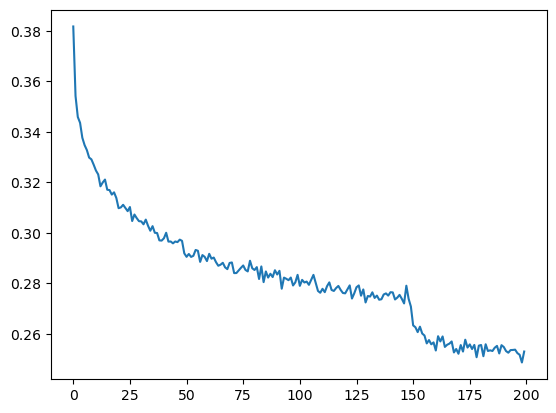

In [62]:
plt.plot(torch.tensor(lossi).view((-1, 1000)).mean(1))

In [63]:
for layer in model.layers:
    layer.training = False

In [64]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (X_train, Y_train),
        "val": (X_dev, Y_dev),
        "test": (X_test, Y_test),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")


train 1.766410231590271
val 2.0025136470794678


In [65]:
for _ in range(20):
    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # ------------
        # forward pass:
        logits = model(torch.tensor([context]))
        # ------------
        # Sample
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)

    print("".join(itos[i] for i in out))


apoljoe
otta
heagon
javye
meela
waiden
airahro
claris
brennen
blayta
arah
astacia
annayveon
zayely
cassedin
letmit
dawdeng
gian
nataliya
carmela
